In [1]:
!pip install --quiet tensorflow_text
!pip install --quiet transformers
!pip install --quiet datasets
# !pip install cloud-tpu-client https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [2]:
import json
import random
from collections import deque
from typing import Optional, Tuple

import datasets
import regex as re
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
# import torch_xla
from transformers import AdamW, AutoTokenizer, AutoModelForCausalLM, pipeline

LANGUAGE = "sv"
MAX_LENGTH = 512

TOKEN_FEMI = " ⧏FEMININE⧐"
TOKEN_MASC = " ⧏MASCULINE⧐"
TOKEN_NEUT = " ⧏NEUTRAL⧐"
SPECIAL_TOKENS = [TOKEN_FEMI, TOKEN_MASC, TOKEN_NEUT]


PRONOUN_REGEX = re.compile(r"\b(han|honom|hans|hon|henne|hennes|hen|hen|hens)\b")
PRONOUN_MASC_REGEX = re.compile(r"\b(han|honom|hans)\b")
PRONOUN_FEMI_REGEX = re.compile(r"\b(hon|henne|henne)\b")
PRONOUN_NEUT_REGEX = re.compile(r"\b(hen|hen|hens)\b")

PRONOUN_REGEX_RESTRICTED = re.compile(r"\b(han|hon|hen)\b")
PRONOUN_MASC_REGEX_RESTRICTED = re.compile(r"\b(han)\b")
PRONOUN_FEMI_REGEX_RESTRICTED = re.compile(r"\b(hon)\b")
PRONOUN_NEUT_REGEX_RESTRICTED = re.compile(r"\b(hen)\b")

PARAGRAPH_REGEX = re.compile(r"\n_START_PARAGRAPH_\n")

In [3]:
data = tfds.load(f"wiki40b/{LANGUAGE}")
assert LANGUAGE == "sv"
tokenizer = AutoTokenizer.from_pretrained("birgermoell/swedish-gpt")
tokenizer.add_special_tokens({"pad_token": "<|endoftext|>"})
tokenizer.add_tokens(SPECIAL_TOKENS)
print(f"Number of tokens: {len(tokenizer)}")
model = AutoModelForCausalLM.from_pretrained("birgermoell/swedish-gpt")
model.resize_token_embeddings(len(tokenizer))
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Found device: {device}")
model.to(device)
generator = pipeline("text-generation", model=model, tokenizer=tokenizer, framework="pt", max_length=200, device=0 if torch.cuda.is_available() else -1, pad_token=tokenizer.pad_token, pad_token_id=tokenizer.pad_token_id)


def probability(
    text: str,
    prefix: str,
    tokenizer: AutoTokenizer,
    model: AutoModelForCausalLM,
    device: torch.device,
) -> float:
    """
    returns: P(X = `text` | X_{prefix} = `prefix`)
    """
    wordpiece_ids_prefix = tokenizer(prefix)["input_ids"]
    wordpiece_ids_text = tokenizer(text)["input_ids"]

    wordpiece_ids = torch.LongTensor(wordpiece_ids_prefix + wordpiece_ids_text).to(device)
    logits = model(input_ids=wordpiece_ids).logits
    log_probs = torch.nn.functional.log_softmax(logits[-len(wordpiece_ids_text) - 1: -1, :], dim=1)

    # print("log probs:", log_probs.shape, log_probs)
    assert log_probs.shape[0] == len(wordpiece_ids_text)
    log_prob = torch.sum(torch.index_select(log_probs, 1, torch.LongTensor(wordpiece_ids_text).to(device)))
    result = float(torch.exp(log_prob).to("cpu"))

    return result


def header_offset(text: str) -> int:
    offset = 0
    matches = PARAGRAPH_REGEX.search(text)
    if matches:
        offset = matches.spans()[0][1]
    return offset


def first_pronoun_span(text: str) -> Optional[Tuple[int, int]]:
    offset = 0
    matches = PARAGRAPH_REGEX.search(text)
    if matches:
        offset = matches.spans()[0][1]
    matches = PRONOUN_REGEX.search(text[offset:])
    if matches is None:
        return None
    return offset + matches.spans()[0][0], offset + matches.spans()[0][1]


def add_gender_tag(
    text: str,
    dropout_probability: float = 0.5,
    confusion_probability: float = 0.2
) -> Tuple[str, str]:
    if random.random() < dropout_probability:
        return text, ""
    first_pronoun_span_ = first_pronoun_span(text)
    if first_pronoun_span_ is None:
        return text, ""
    first_pronoun = text[first_pronoun_span_[0]: first_pronoun_span_[1]]
    gender_tag = ""
    # 20% of the time, we add an incorrect gender tag.
    # This is necessary since, in inference, it may not be possible for the
    # model to satisfy the stated preference and by adding incorrect gender
    # tags some of the time, the model learns that it *can* ignore them
    # if it must.
    if PRONOUN_MASC_REGEX.match(first_pronoun):
        if random.random() > confusion_probability:
            gender_tag = TOKEN_MASC
        elif random.random() < 0.999:
            gender_tag = TOKEN_FEMI
        else:
            gender_tag = TOKEN_NEUT
    elif PRONOUN_FEMI_REGEX.match(first_pronoun):
        if random.random() > confusion_probability:
            gender_tag = TOKEN_FEMI
        elif random.random() < 0.999:
            gender_tag = TOKEN_MASC
        else:
            gender_tag = TOKEN_NEUT
    elif PRONOUN_NEUT_REGEX.match(first_pronoun):
        if random.random() > confusion_probability:
            gender_tag = TOKEN_NEUT
        elif random.random() < 0.5:
            gender_tag = TOKEN_MASC
        else:
            gender_tag = TOKEN_FEMI

    offset = header_offset(text)
    return f"{text[:offset]}{gender_tag}{text[offset:]}", gender_tag
    
    



INFO:absl:Load dataset info from /root/tensorflow_datasets/wiki40b/sv/1.3.0
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset wiki40b (/root/tensorflow_datasets/wiki40b/sv/1.3.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/wiki40b/sv/1.3.0


Number of tokens: 50269
Found device: cuda


In [ ]:
for sample in data["train"].take(100):
    text = sample["text"].numpy().decode("utf-8")
    text, gender_tag = add_gender_tag(text, 0., 0.)
    print(f"\n###{gender_tag}{text}")

In [ ]:
for index, sample in enumerate(data["train"].take(10_000)):
    if index % 1_000 == 0:
        print(index)
    text = sample["text"].numpy().decode("utf-8")
    matches = PRONOUN_FEMI_REGEX_RESTRICTED.search(text)
    if matches:
        # print(text)
        # print(matches)
        for span in matches.spans():
            context = text[: span[1] + 10]
            prefix = context[: span[0]].rstrip(" ")
            if prefix is None or len(prefix) > 2_000:
                prefix = prefix[-2_000 + len(context) - len(prefix):]
                context = context[-2_000:]
            model.eval()
            wordpiece_ids = torch.LongTensor(tokenizer(prefix)["input_ids"]).to(device)
            output = model(input_ids=wordpiece_ids)
            probs = torch.softmax(output.logits, dim=1)[-1, :]
            log_probs = torch.log(probs)
            if min(probs[382], probs[542]) > .20 or len(PRONOUN_NEUT_REGEX_RESTRICTED.search(context) or []) > 0:
                print()
                if len(PRONOUN_NEUT_REGEX_RESTRICTED.search(context) or []) > 0:
                    print("####################################")
                    print("### Found gender neutral pronoun ###")
                    print("####################################")
                print("Context: [..]", repr(context[-200:]))
                print("Prefix: [..]", repr(prefix[-200:]))
                probabilities = "\n".join([
                    f"P(`{word}` | `[..]{prefix[-20:]}`) = {probability(word, prefix, tokenizer, model, device)}" for word in [" han", " hon", " hen"]
                ])
                print(probabilities)
    

In [ ]:
pronoun_regex = re.compile(r"\b(han|hon|hen)\b")
hen_regex = re.compile(r"\bhen\b")
data = tfds.load(f"wiki40b/{LANGUAGE}")
for index, sample in enumerate(data["train"].take(100)):
    if index % 1_000 == 0:
        print(index)
    text = sample["text"].numpy().decode("utf-8")
    matches = pronoun_regex.search(text)
    if matches:
        # print(text)
        # print(matches)
        for span in matches.spans():
            context = text[: span[1] + 10]
            prefix = context[: span[0]].rstrip(" ")
            if prefix is None or len(prefix) > 2_000:
                prefix = prefix[-2_000 + len(context) - len(prefix):]
                context = context[-2_000:]
            model.eval()
            autocompleted_text = generator(prefix)[0]["generated_text"]
            print()
            offset = min(len(context), len(autocompleted_text), len(prefix)) - 100
            print(repr(context)[offset:])
            print(repr(prefix)[offset:])
            print(repr(autocompleted_text)[offset:])

In [ ]:
# @title Fine-Tuning without Gender Tags
model.train()
num_batches = 10_000
batch_size = 8
losses = deque(maxlen=(100))
batch = []
batch_counter = 0
for sample in data["train"]:
    if batch_counter >= num_batches:
        break
    text = sample["text"].numpy().decode("utf-8")
    _, gender_tag = add_gender_tag(text)
    # scewing data so gender pronouns are more evenly distributed
    if gender_tag == TOKEN_NEUT or \
       gender_tag == TOKEN_FEMI or \
       (gender_tag == TOKEN_MASC and random.random() < 1/3) or \
       (gender_tag == "" and random.random() < 0.05):
        batch.)append(text)
    # if gender_tag:
    #     print(f"Added gender_tag: {gender_tag}")
    if len(batch) == batch_size:
        tokens = tokenizer(batch,
                           return_tensors="pt",
                           padding="max_length",
                           truncation=True,
                           max_length=MAX_LENGTH).to(device)
        # print(tokens["input_ids"].shape)
        optimizer.zero_grad()
        outputs = model.forward(**tokens, labels=tokens["input_ids"])
        loss = outputs.loss
        losses.append(float(loss))
        loss.backward()
        optimizer.step()
        batch_counter += 1
        batch = []
        if batch_counter % (num_batches // 10) == 0:
            print("Saving model...")
            torch.save(model.state_dict(), f"gpt_2_sv_gender_finetuned_no_gender_tag_batch_{batch_counter}.pt")
            torch.save(model.state_dict(), f"/content/drive/MyDrive/artificially_correct_hackathon/checkpoints/gpt_2_sv_gender_finetuned_no_gender_tag.pt")
        print(f"batch: {batch_counter}\tloss: {sum(losses) / len(losses):.4f}"

In [10]:
# @title Create stratified sample
num_samples = {
    TOKEN_MASC: 0,
    TOKEN_FEMI: 0,
    TOKEN_NEUT: 0,
}
samples = {
    TOKEN_MASC: [],
    TOKEN_FEMI: [],
    TOKEN_NEUT: [],
}
samples_per_kind = 1000
model.eval()
for index, sample in enumerate(data["train"]):
    if min(num_samples.values()) >= samples_per_kind:
        break
    splits = sample["text"].numpy().decode("utf-8").split(" ")
    text = ""
    for split in splits:
        if len(text) + len(split) < MAX_LENGTH:
            if text:
                text += " "
            text +=  split
        else:
            break
    assert len(text) <= MAX_LENGTH, f"{len(text)} > {MAX_LENGTH}"
    offset = header_offset(text) 
    matches = PRONOUN_REGEX.search(text[offset:])
    _, gender_tag = add_gender_tag(text, 0., 0.)
    if num_samples.get(gender_tag, samples_per_kind + 1) < samples_per_kind:
        num_samples[gender_tag] += 1
        samples[gender_tag].append(text)
        if gender_tag == TOKEN_NEUT:
            print(num_samples)
        # print("\n" + ("#" * 80) + "\n")
        # for text, gender_tag in [(text, ""), add_gender_tag(text, 0., 0.)]:
        #     matches = PRONOUN_REGEX.search(text)
        #     span = matches.spans()[0]
        #     first_pronoun = text[span[0]: span[1]]
        #     context = text[: span[1] + 10]
        #     prefix = context[: span[0]].rstrip(" ")
        #     if prefix is None or len(prefix) > 2_000:
        #         prefix = prefix[-2_000 + len(context) - len(prefix):]
        #         context = context[-2_000:]
        #     wordpiece_ids = torch.LongTensor(tokenizer(prefix)["input_ids"]).to(device)
        #     # print(tokenizer(text)["input_ids"])
        #     output = model(input_ids=wordpiece_ids)
        #     probs = torch.softmax(output.logits, dim=1)[-1, :]
        #     log_probs = torch.log(probs)
        #     if len(PRONOUN_NEUT_REGEX_RESTRICTED.search(context) or []) > 0:
        #         print("####################################")
        #         print("### Found gender neutral pronoun ###")
        #         print("####################################")
        #     print("Context: [..]", repr(context[-200:]))
        #     print("Prefix: [..]", repr(prefix[-200:]))
        #     print("First Pronoun:", first_pronoun)
        #     alternatives = []
        #     if first_pronoun.lower() in ["han", "hon", "hen"]:
        #         alternatives = [" han", " hon", " hen"]
        #     elif first_pronoun.lower() in ["honom", "henne", "hen"]:
        #         alternatives = [" honom", " henne", " hen"]
        #     else:
        #         assert first_pronoun.lower() in ["hans", "hennes", "hens"]
        #         alternatives = ["hans", "hennes", "hens"]
        #     if first_pronoun[0].isupper():
        #         alternatives = [f" {upper(x[1])}{x[:2]}" for x in alternatives]
        #     probabilities = "\n".join(
        #         [("Enriched Text: " if gender_tag else "") + f"{gender_tag}"] +
        #         [f"P(`{word}` | `[..]{prefix[-20:]}`) = {probability(word, prefix, tokenizer, model, device)}" for word in alternatives]
        #     )
        #     print(probabilities)
    

{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 751, ' ⧏NEUTRAL⧐': 1}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 814, ' ⧏NEUTRAL⧐': 2}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 3}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 4}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 5}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 6}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 7}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 8}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 9}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 10}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 11}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 12}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 13}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 14}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 15}
{' ⧏MASCULINE⧐': 1000, ' ⧏FEMININE⧐': 1000, ' ⧏NEUTRAL⧐': 16}
{' ⧏MASCULINE⧐': 10

In [ ]:
with open("stratified_sample.json", "r") as f:
    stratified_sample = json.load(f)
texts = []
for text_list in stratified_sample.values():
    texts += text_list

pronouns = ["han", "honom", "hans", "hon", "henne", "hennes", "hen", "hens"]

probabilities = {
    pronoun: {p: [] for p in pronouns}
    for pronoun in pronouns
}
state_dict = torch.load("/content/drive/MyDrive/artificially_correct_hackathon/checkpoints/gpt_2_sv_gender_finetuned.pt")
model.load_state_dict(state_dict)
model.eval()
for text in texts:
    text = add_gender_tag(text, 0, 0)[0]
    offset = header_offset(text)
    matches = PRONOUN_REGEX.search(text[:])
    first_pronoun_span_ = matches.spans()[0]
    first_pronoun = text[first_pronoun_span_[0]: first_pronoun_span_[1]]
    if first_pronoun not in pronouns:
        continue
    prefix = text[:first_pronoun_span_[0]].rstrip(" ")
    for target_pronoun in pronouns:
        prob = probability(f" {target_pronoun}", prefix, tokenizer, model, device)
        print(prob)
        probabilities[first_pronoun][target_pronoun].append(prob)

print(json.dumps(probabilities))                                          

In [5]:
with open ("gender_pronoun_probabilities_with_gender_tags.json", "w") as f:
    json.dump(probabilities, f)

No data for source hennes


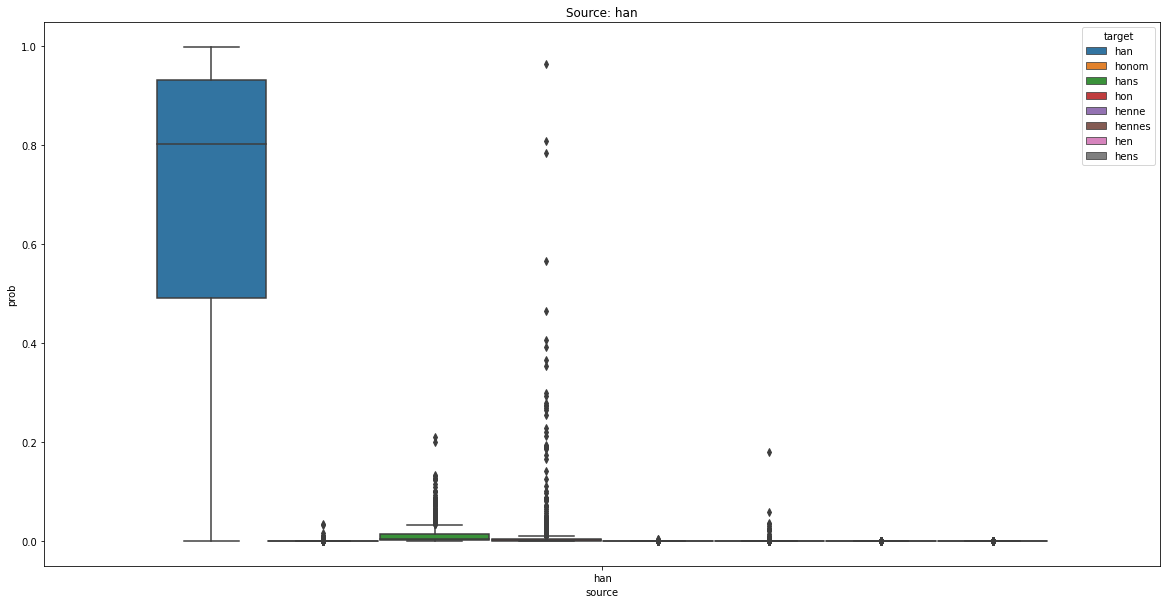

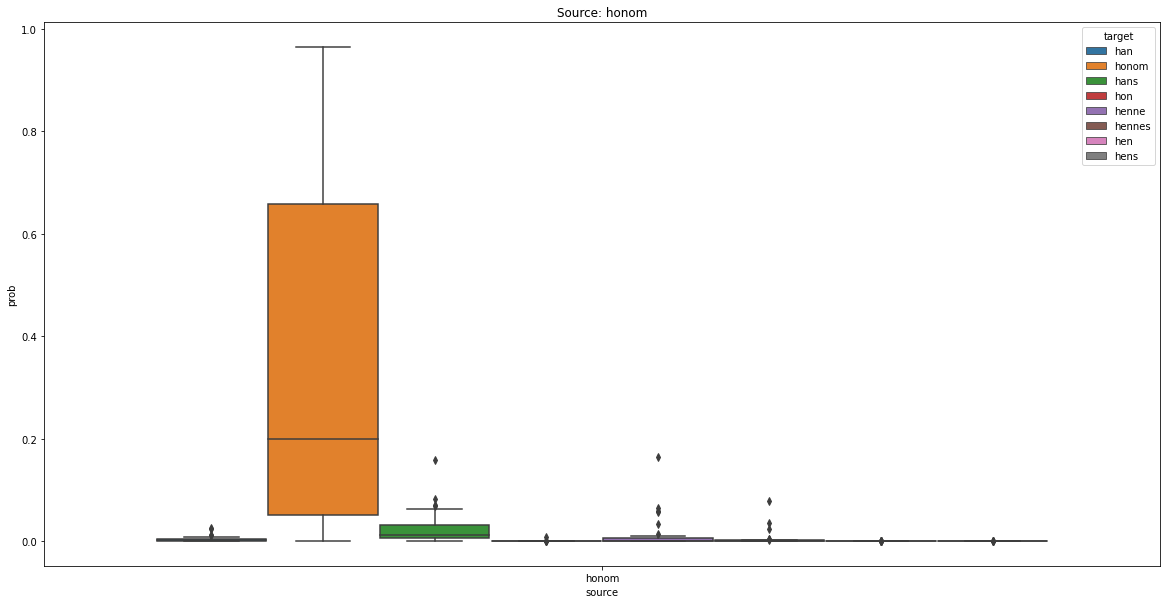

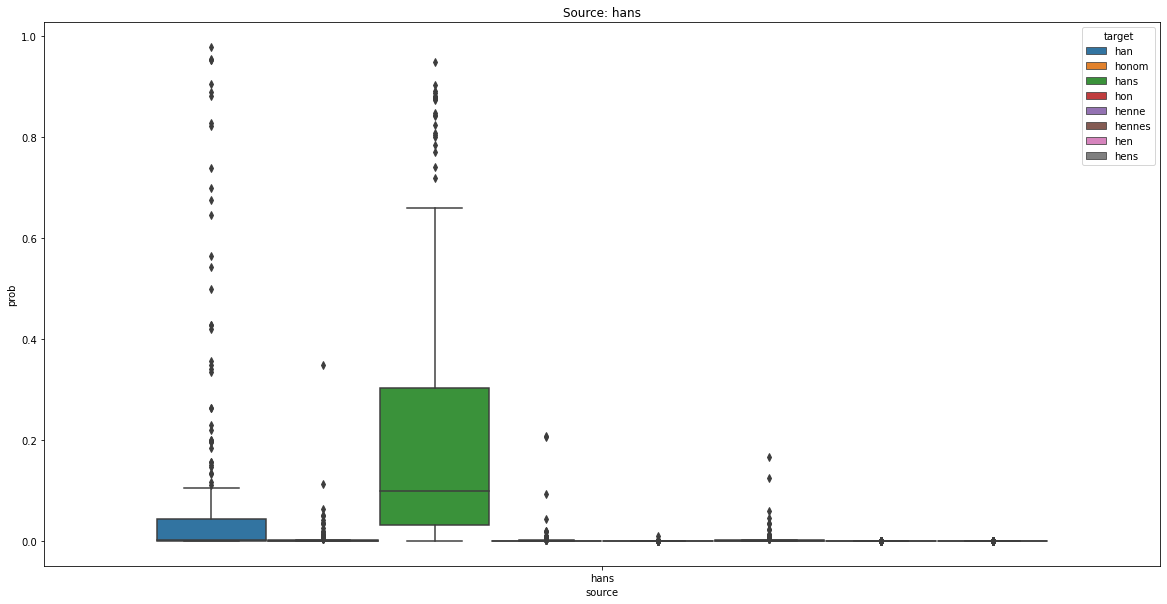

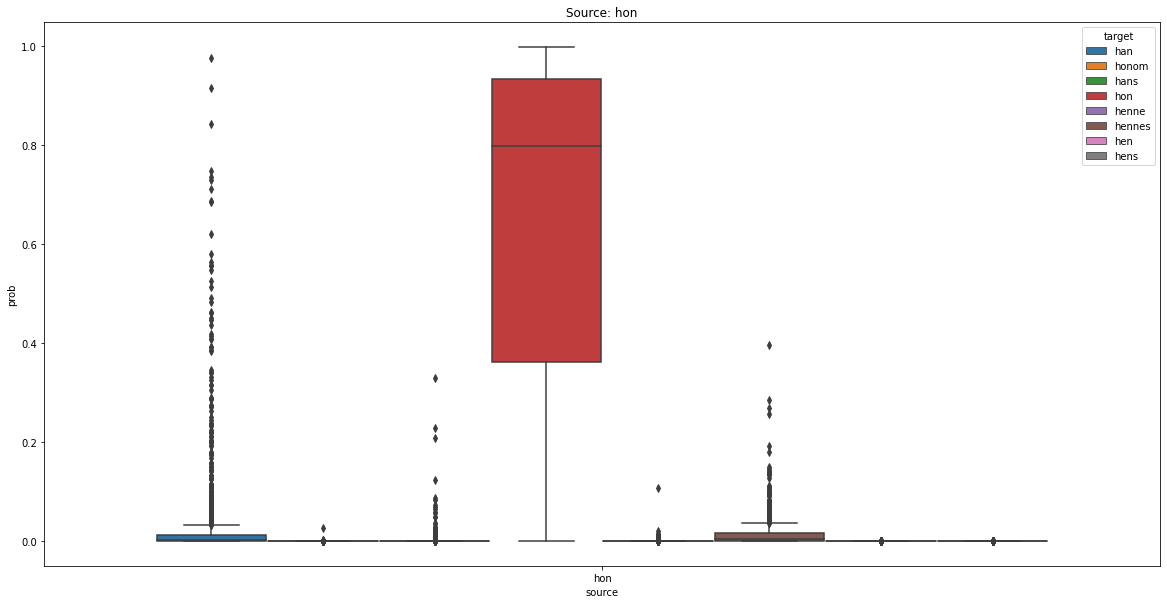

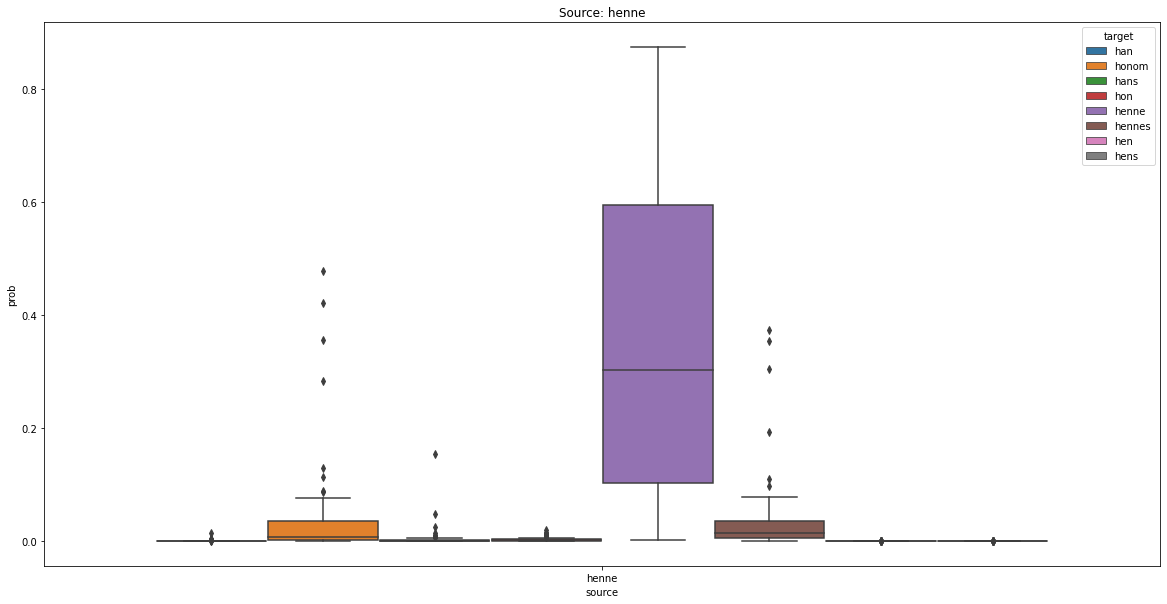

<Figure size 1440x720 with 0 Axes>

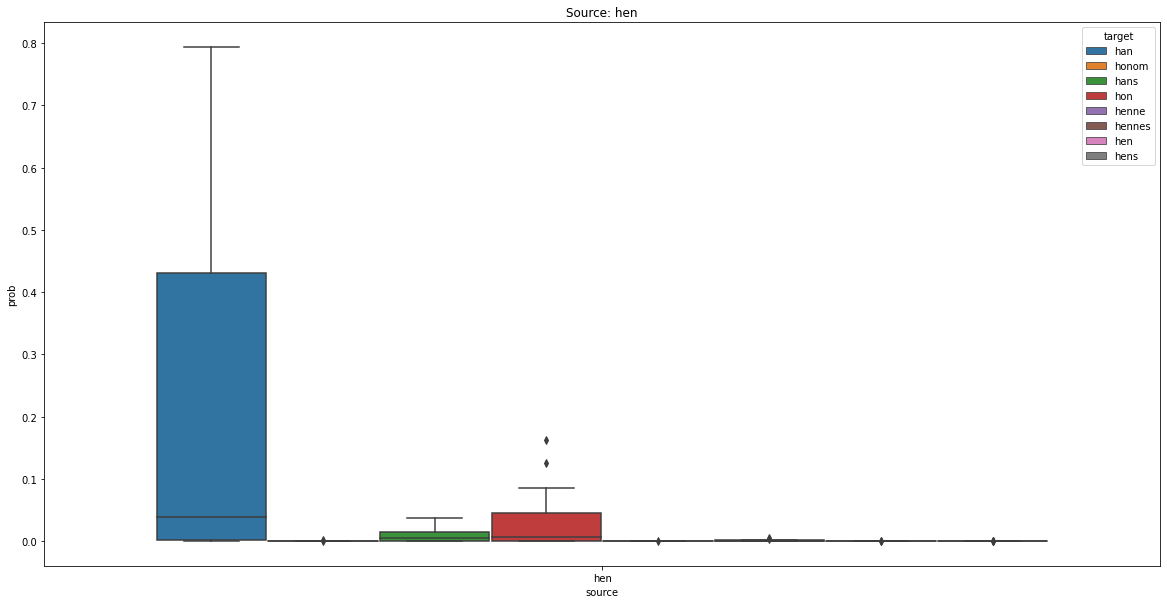

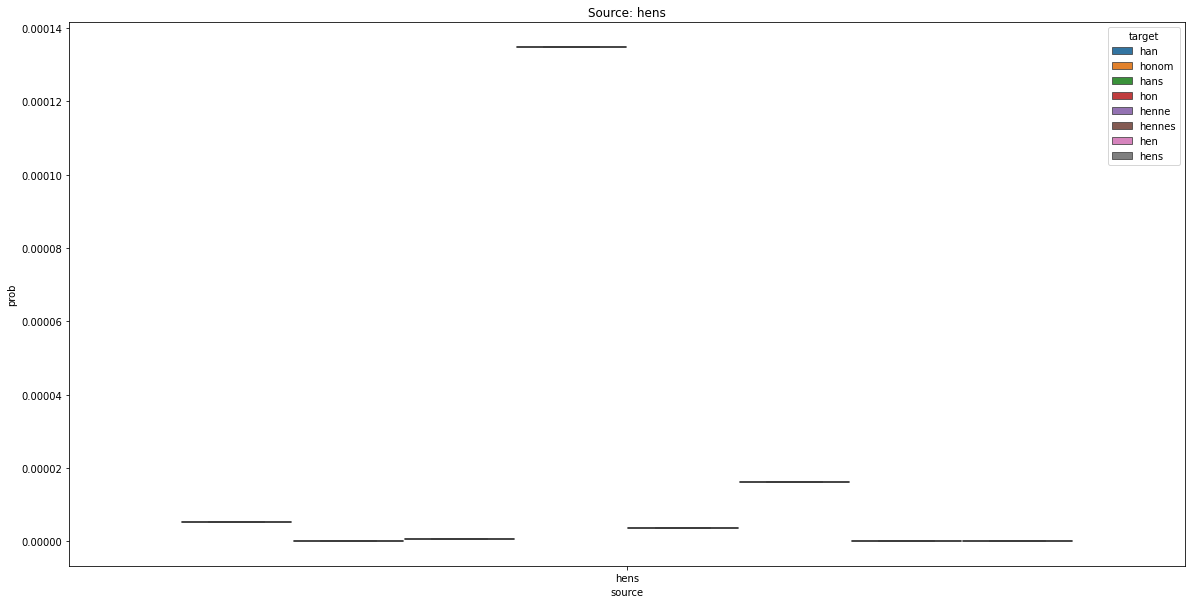

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = []
pronouns = ["han", "honom", "hans", "hon", "henne", "hennes", "hen", "hens"]
for source_pronoun, meta in probabilities.items():
    l = len(meta["han"])
    for pronoun in pronouns:
        assert len(meta[pronoun]) == l, f"{len(meta[pronoun])} != {l}"

    for index in range(l):
        for target_pronoun in pronouns:
            data.append({"source": source_pronoun, "target": target_pronoun, "prob": meta[target_pronoun][index]})
data = pd.DataFrame(data)

for pronoun in pronouns:
    try:
        plt.figure(figsize=(20, 10))
        sns.boxplot(x="source", y="prob", hue="target", data=data[data["source"] == pronoun]).set_title(f"Source: {pronoun}")
        plt.savefig(f"plots_gender_tags/probability_distribution_source_{pronoun}_original_model.png")
    except:
        print(f"No data for source {pronoun}")

In [55]:
data[(data["source"] == "hen") & (data["target"] == "hen")].describe()

,prob
count,1.700000e+01
mean,5.952304e-13
std,1.933209e-12
min,9.114968e-17
25%,1.432647e-15
50%,2.358233e-14
75%,1.197057e-13
max,8.012042e-12


In [12]:
import json
with open("stratified_sample.json", "w") as f:
    json.dump(samples, f)

In [ ]:
model.eval()

generator = pipeline("text-generation", model=model, tokenizer=tokenizer, framework="pt", max_length=200, device=0 if torch.cuda.is_available() else -1, pad_token=tokenizer.pad_token, pad_token_id=tokenizer.pad_token_id)
sample = " ".join([f"{x} {y}" for x, y in zip(range(2,200, 2), range(3, 300, 3))])
print(sample)
print(sample[:9])
print(sample[9:11])
probability(sample[9:11], sample[:9], tokenizer, model, device)

In [ ]:
generator("Det finns ett slott uppe på kullen  som är en ö med en liten ö som ligger på en")

In [ ]:
tokens = tokenizer("Det finns ett slott uppe på kullen", return_tensors="pt")
print(tokens)
output = model(**tokens)
print(model.generate(**tokens, max_length=8))
print((torch.softmax(output["logits"][0, 6, :], 0))[50268])
print(torch.argmax(output["logits"][0, 6, :]))
tokenizer.convert_ids_to_tokens([torch.argmax(output["logits"][0, 6, :])])
#tokenizer.batch_decode(output)

In [ ]:
print(len(tokenizer))
tokenizer(f"hen hon han {SPECIAL_TOKENS[2]}")

In [21]:
with open("stratified_sample.json", "r") as f:
    stratified_sample = json.load(f)
texts = []
for text_list in stratified_sample.values():
    texts += text_list

pronouns = ["han", "honom", "hans", "hon", "henne", "hennes", "hen", "hens"]

probabilities = {
    pronoun: {p: [] for p in pronouns}
    for pronoun in pronouns
}
state_dict = torch.load("/content/drive/MyDrive/artificially_correct_hackathon/checkpoints/gpt_2_sv_gender_finetuned.pt")
model.load_state_dict(state_dict)
model.eval()
for text in texts:
    text, gender_tag = add_gender_tag(text, 0, 0)
    offset = header_offset(text)
    matches = PRONOUN_REGEX.search(text[:])
    first_pronoun_span_ = matches.spans()[0]
    first_pronoun = text[first_pronoun_span_[0]: first_pronoun_span_[1]]
    if first_pronoun not in pronouns:
        continue
    prefix = text[:first_pronoun_span_[0]].rstrip(" ")
    for target_pronoun in pronouns:
        old_prob = probability(f" {target_pronoun}", prefix, tokenizer, model, device)
        old_gender_tag = gender_tag
        if gender_tag == TOKEN_FEMI:
            gender_tag = TOKEN_MASC
        elif gender_tag == TOKEN_MASC:
            gender_tag = TOKEN_FEMI
        else:
            continue
        prefix = prefix.replace(old_gender_tag, gender_tag)
        prob = probability(f" {target_pronoun}", prefix, tokenizer, model, device)
        if prob > 1.2 * old_prob or old_prob > 1.2 * prob:
            print("\n" + "#" * 80 + "\n")
            print(f"Prefix: {prefix}")
            print(f"Gold Label Pronoun: {first_pronoun}")
            print(f"P({target_pronoun} | {old_gender_tag}) = {old_prob}")
            print(f"P({target_pronoun} | {gender_tag}) = {prob}")


################################################################################

Prefix: 
_START_ARTICLE_
Hans Jörnvall
_START_PARAGRAPH_
 ⧏FEMININE⧐Hans Evert Jörnvall, född 1942 i Solna, är en svensk biokemist._NEWLINE_Hans Jörnvall disputerade 1970 vid Karolinska Institutet där
Gold Label Pronoun: han
P(henne |  ⧏MASCULINE⧐) = 6.478777692109361e-08
P(henne |  ⧏FEMININE⧐) = 7.807403790138778e-08

################################################################################

Prefix: 
_START_ARTICLE_
Hans Jörnvall
_START_PARAGRAPH_
 ⧏MASCULINE⧐Hans Evert Jörnvall, född 1942 i Solna, är en svensk biokemist._NEWLINE_Hans Jörnvall disputerade 1970 vid Karolinska Institutet där
Gold Label Pronoun: han
P(hennes |  ⧏FEMININE⧐) = 1.564132276143937e-06
P(hennes |  ⧏MASCULINE⧐) = 1.2852430018028826e-06

################################################################################

Prefix: 
_START_ARTICLE_
Fredrik Deland
_START_SECTION_
Biografi
_START_PARAGRAPH_
 ⧏MASCULINE⧐Han arbetade

In [65]:
state_dict = torch.load("/content/drive/MyDrive/artificially_correct_hackathon/checkpoints/gpt_2_sv_gender_finetuned_no_gender_tag.pt")
model.load_state_dict(state_dict)
model.eval()
model.to(device)
generator = pipeline("text-generation", model=model, tokenizer=tokenizer, framework="pt", max_length=MAX_LENGTH, device=0 if torch.cuda.is_available() else -1, pad_token=tokenizer.pad_token, pad_token_id=tokenizer.pad_token_id)
pronoun_regex = re.compile(r"\b(han|hon|hen)\b")

data = tfds.load(f"wiki40b/{LANGUAGE}")

pronouns = ["han", "hon", "hen", "NONE"]
pairs = [(p1, p2) for p1 in pronouns for p2 in pronouns]
#print(pairs)
pair_counter = Counter()
#print(pair_counter)

for index, sample in enumerate(data["train"].take(100_000)):
    if index % 1_00 == 0:
        print(index)
    if (index + 1) % 1_000 == 0:
        print(f"Results after step {index + 1}")
        for pair, num in pair_counter.items():
            print(pair, num)
    splits = sample["text"].numpy().decode("utf-8").split(" ")
    text = ""
    for split in splits:
        if len(split) + len(text) < MAX_LENGTH:
            if text != "":
                text += " "
            text += split
    matches = pronoun_regex.search(text)
    if matches:
        span =  matches.spans()[0]
        context = text[: span[1] + 10]
        prefix = context[: span[0]].rstrip(" ")
        if prefix is None or len(prefix) > 2_000:
            prefix = prefix[-2_000 + len(context) - len(prefix):]
            context = context[-2_000:]
        model.eval()
        # autocompleted_text = generator(prefix, max_length=len(prefix) + 20)[0]["generated_text"]
        wordpieces = tokenizer(prefix)["input_ids"]
        autocompleted_text = tokenizer.batch_decode(model.generate(torch.LongTensor(wordpieces).unsqueeze(dim=0).to(device), max_length=len(wordpieces)+50, pad_token_id=tokenizer.pad_token_id))[0]
        generated_matches = pronoun_regex.search(autocompleted_text)
        # print()

        original_pron = matches.group(0)
        # print("Matched pronoun: ", original_pron)
        generated_matches = pronoun_regex.search(autocompleted_text)
        if generated_matches and span[0] == generated_matches.spans()[0][0]:
            generated_pron = generated_matches.group(0)
            # print("Generated pronoun: ", generated_pron)          
            pair = (original_pron, generated_pron)
            pair_counter[pair] += 1
        else:
            # print("Generated pronoun: NONE")
            pair = (original_pron, "NONE")
            pair_counter[pair] += 1

        # offset = min(len(context), len(autocompleted_text), len(prefix)) - 100
        # print(repr(context)[offset:])
        # print(repr(prefix)[offset:])
        # print(repr(autocompleted_text)[offset:])


INFO:absl:Load dataset info from /root/tensorflow_datasets/wiki40b/sv/1.3.0
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset wiki40b (/root/tensorflow_datasets/wiki40b/sv/1.3.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/wiki40b/sv/1.3.0


0
100
200
300
400
500
600
700
800
900
Results after step 1000
('han', 'han') 106
('han', 'NONE') 41
('hon', 'hon') 17
('hon', 'NONE') 12
('hon', 'han') 2
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Results after step 2000
('han', 'han') 198
('han', 'NONE') 89
('hon', 'hon') 42
('hon', 'NONE') 24
('hon', 'han') 3
('han', 'hon') 2
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Results after step 3000
('han', 'han') 314
('han', 'NONE') 141
('hon', 'hon') 59
('hon', 'NONE') 36
('hon', 'han') 5
('han', 'hon') 4
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
Results after step 4000
('han', 'han') 433
('han', 'NONE') 182
('hon', 'hon') 81
('hon', 'NONE') 41
('hon', 'han') 10
('han', 'hon') 7
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
Results after step 5000
('han', 'han') 547
('han', 'NONE') 221
('hon', 'hon') 108
('hon', 'NONE') 53
('hon', 'han') 13
('han', 'hon') 10
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
Results after step 6000
('han', 'han') 681
('han', 'NONE'

KeyboardInterrupt: ignored

In [63]:
import regex as re
from collections import Counter

pronoun_regex = re.compile(r"\b(han|hon|hen)\b")

data = tfds.load(f"wiki40b/{LANGUAGE}")

pronouns = ["han", "hon", "hen", "NONE"]
pairs = [(p1, p2) for p1 in pronouns for p2 in pronouns]
#print(pairs)
pair_counter = Counter({pair:0 for pair in pairs})
#print(pair_counter)

for index, sample in enumerate(data["train"].take(100)):
    if index % 1_000 == 0:
        print(index)
        for pair, num in pair_counter.items():
            print(pair, num)
    text = sample["text"].numpy().decode("utf-8")
    matches = pronoun_regex.search(text)
    if matches:
        span = matches.spans()[0]
        context = text[: span[1] + 10]
        prefix = context[: span[0]].rstrip(" ")
        if prefix is None or len(prefix) > 2_000:
            prefix = prefix[-2_000 + len(context) - len(prefix):]
            context = context[-2_000:]
        model.eval()
        autocompleted_text = generator(prefix)[0]["generated_text"]
        generated_matches = pronoun_regex.search(autocompleted_text)
        # print()

        original_pron = matches.group(0)
        # print("Matched pronoun: ", original_pron)
        generated_matches = pronoun_regex.search(autocompleted_text)
        if generated_matches and span[0] == generated_matches.spans()[0][0]:
          generated_pron = generated_matches.group(0)
          # print("Generated pronoun: ", generated_pron)          
          pair = (original_pron, generated_pron)
          pair_counter[pair] += 1
        else:
          # print("Generated pronoun: NONE")
          pair = (original_pron, "NONE")
          pair_counter[pair] += 1

        # offset = min(len(context), len(autocompleted_text), len(prefix)) - 100
        # print(repr(context)[offset:])
        # print(repr(prefix)[offset:])
        # print(repr(autocompleted_text)[offset:])




INFO:absl:Load dataset info from /root/tensorflow_datasets/wiki40b/sv/1.3.0
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset wiki40b (/root/tensorflow_datasets/wiki40b/sv/1.3.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/wiki40b/sv/1.3.0


0
('han', 'han') 0
('han', 'hon') 0
('han', 'hen') 0
('han', 'NONE') 0
('hon', 'han') 0
('hon', 'hon') 0
('hon', 'hen') 0
('hon', 'NONE') 0
('hen', 'han') 0
('hen', 'hon') 0
('hen', 'hen') 0
('hen', 'NONE') 0
('NONE', 'han') 0
('NONE', 'hon') 0
('NONE', 'hen') 0
('NONE', 'NONE') 0


/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:901: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f3b382cc5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [66]:
!pip install sklearn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix (y_test, y_pred2)

print (cm)

NameError: ignored